# Chapter 9. Unsupervised Learning Techniques



In [106]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

np.random.seed(0)

plt.style.use('seaborn-whitegrid')

In [107]:
%matplotlib inline

In [108]:
%load_ext ipycache

/opt/anaconda3/envs/daysOfCode-env/lib/python3.7/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated since IPython 4.0. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/opt/anaconda3/envs/daysOfCode-env/lib/python3.7/site-packages/ipycache.py:17: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils.traitlets import Unicode


This chapter covers the following unsupervised learning techniques: clustering, anomaly detection, and density estimation.

## Clustering

*Clustering* is the task of identifying similar instances and assigning them to groups.

The author discusses some useful tasks for clustering:

1. At the beginning of a data analysis, the data can be clustered and then each cluster can be analyzed separately.
2. Once clusters have been assigned, the affinity values for each cluster can be used for dimensionality reduction.
3. Anomalies can be detected as those that don't fit into a cluster.
4. Label propagation from labeled data to new unlabeled data for semi-supervised learning.

### K-means

Below is an example of K-means clustering on artificial data made of blobs.

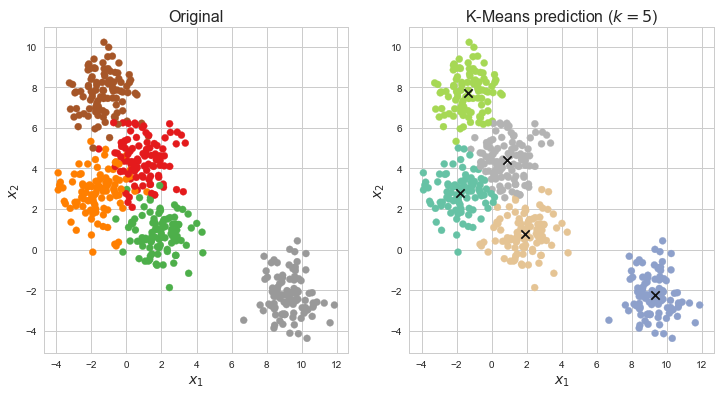

In [109]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

# Artifical data.
X, y = make_blobs(n_samples=500, centers=5, random_state=0)

# K-means clustering.
k = 5  # The number of clusters to find.
kmeans = KMeans(n_clusters=k)
kmeans.fit(X)

# Make classifications from K-means model.
y_pred = kmeans.predict(X)


# Plotting.
fig = plt.figure(figsize=(12, 6))

# Plot the original clusters.
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='Set1')
plt.xlabel('$x_1$', fontsize=14)
plt.ylabel('$x_2$', fontsize=14)
plt.title('Original', fontsize=16)

# Plot the K-means classifications.
plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap='Set2')
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], c='k', s=70, marker='x')

plt.xlabel('$x_1$', fontsize=14)
plt.ylabel('$x_2$', fontsize=14)
plt.title(f'K-Means prediction ($k={k}$)', fontsize=16)
plt.show()

In [110]:
# Show the centers of the clusters.
kmeans.cluster_centers_

array([[-1.78783991,  2.76785611],
       [ 9.30286933, -2.23802673],
       [-1.33625465,  7.73822965],
       [ 1.87544954,  0.76337636],
       [ 0.87407478,  4.4332834 ]])

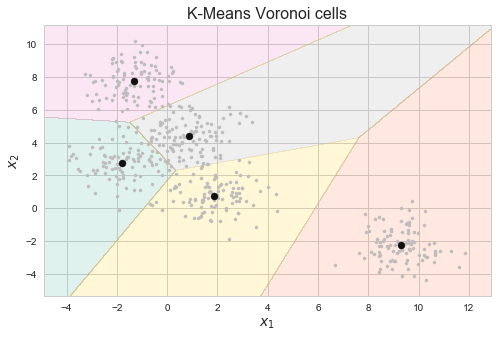

In [111]:
# Create Voronoi cells by predicting over a mesh.
h = .02  # step size of the mesh grid.
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
x0, x1 = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
X_mesh = np.c_[x0.ravel(), x1.ravel()]
y_pred = kmeans.predict(X_mesh).reshape(x0.shape)

# Plot Voronoi cells.
fig = plt.figure(figsize=(8, 5))

plt.contourf(x0, x1, y_pred, cmap='Set2', alpha=0.2)

plt.scatter(X[:, 0], X[:, 1], c='#bdbdbd', s=10)

plt.scatter(centroids[:, 0], centroids[:, 1], c='k', s=200, marker='.')

plt.xlabel('$x_1$', fontsize=14)
plt.ylabel('$x_2$', fontsize=14)
plt.title(f'K-Means Voronoi cells', fontsize=16)
plt.show()

The performance of K-means clustering degrades when the distributions of the clusters are different.
*Hard-voting* is when each instance is assigned to a single cluster.
Alternatively, *soft-voting* is when a score is assigned to each instance per centroid.
The score can be the distance to the centroid, or a similarity score (affinity) from the Gaussian radial basis function (RBF).
These data can be obtained by using the `transform()` method of a `KMeans` object.
This can act as a dimensionality reduction technique for higher-dimensional data.

In [112]:
kmeans.transform(X[0:5, :])

array([[ 5.65395395,  6.78719721,  9.32888063,  1.65547831,  5.42241143],
       [ 2.29711611, 11.50756245,  3.59157417,  4.11349809,  1.00516713],
       [ 5.24356985, 10.50404117,  4.31832326,  5.04967736,  2.11385281],
       [ 0.72872131, 12.22263029,  4.29719996,  4.32525956,  2.58848823],
       [ 1.71946847, 10.68298997,  5.01631429,  2.87918881,  1.81565044]])

Centroid initialization plays a role in determining the final outcome.
The original method for initialization was to randomly distribute the centroids.
Now, Scikit-Learn's `KMeans` class uses an improved method called *K-Means++* that finds initial locations that are well-distributed in relation to the density of the data.

In addition, the class has an `n_init` property that determines how many times the algorithm is run (the default is 10).
After a number of rounds, the best version is kept.
The quality of the iteration is the *inertia* of the model, that is the MSE of each instance and the nearest centroid.

Scikit-Learn also offers the `MiniBatchKMeans` class that uses a variation of the K-means algorithm to fit the model in batches.
This makes training with a large data set faster.

### Finding the optimal number of clusters

We cannot use the inertia as the metric for the number of clusters because it will always decrease as $k$ increases.
This is shown below.

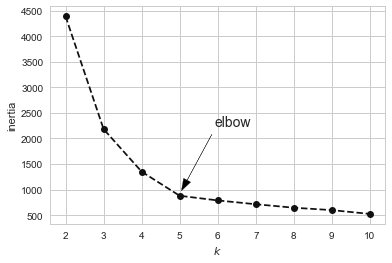

In [113]:
ks = np.arange(2, 11)
intertias = []

for k in ks:
    km = KMeans(n_clusters=k)
    km.fit(X)
    intertias.append(km.inertia_)

plt.plot(ks, intertias, 'k--o')

plt.annotate('elbow', xy=(5, intertias[5]+200),
             xycoords='data', xytext=(0.6, 0.5), 
             textcoords='axes fraction', 
             arrowprops=dict(width=0.1, headwidth=8, facecolor='black', shrink=0.05),
             horizontalalignment='right', verticalalignment='top',
             fontsize=14)

plt.xlabel('$k$')
plt.ylabel('inertia')
plt.show()

The elbow point can be a good indication for the number of clusters, though it is coarse, manual, and imprecise.

Alternatively, the *silhouette score*, the mean of the *silhouette coefficients* for each point, can be a good measure.
An instance's silhouette coefficient is shown below where $a$ is the means distance to the other instances in the same cluster and $b$ is the mean distance to the instances of the next nearest cluster (using the minimum value of all the clusters for $b$).
The value can range from -1 to 1 where the greater the number the more likely the point was assigned correctly.

$$
\frac{b-a}{max(a, b)}
$$

Thankfully, Scikit-Learn offers the `silhouette_score()` function to compute this.

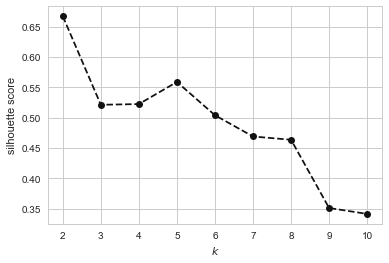

In [114]:
from sklearn.metrics import silhouette_score

ks = np.arange(2, 11)
sil_scores = []

for k in ks:
    km = KMeans(n_clusters=k)
    km.fit(X)
    sil_scores.append(silhouette_score(X, km.labels_))

plt.plot(ks, sil_scores, 'k--o')
plt.xlabel('$k$')
plt.ylabel('silhouette score')
plt.show()

Below are *silhouette diagrams* for multiple K-means models with various $k$ values.
The plot is effectively a horizontal bar plot of each instance's silhouette coefficient, ordered by cluster and rank.
The plot segments into a shape per cluster where the height indicates the number of instances in the cluster and the width reflects on well the instances fit in the clusters.
The red-dotted line indicates the silhouette score for the model.

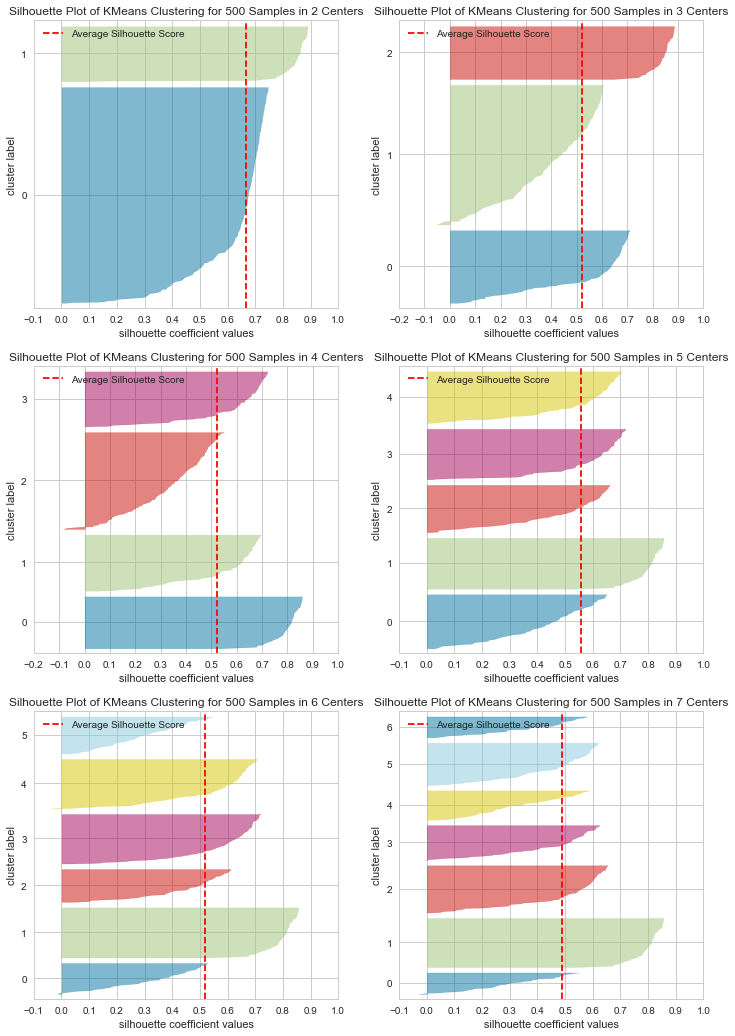

In [115]:
from sklearn.metrics import silhouette_samples
from yellowbrick.cluster import SilhouetteVisualizer

fig = plt.figure(figsize=(12, 18))

for i, k in enumerate(np.arange(2, 8)):
    plt.subplot(3, 2, i+1)
    km = KMeans(n_clusters=k)
    viz = SilhouetteVisualizer(km, colors='yellowbrick')
    viz.fit(X)
    viz.finalize()

plt.show()

Below are some of the limits of K-means:

* can reach suboptimal solutions
* the number of clusters must be declared
* K-means is not great at clustering non-spherical clusters of unequal densities

### Using clustering for image segmentation

Below is an example of using K-means to segment an image by color.

In [116]:
from matplotlib.image import imread
import os

ladybug = imread(os.path.join('assets', 'homl', 'images', 'ladybug.png'))
# ladybug = ladybug[100:300, 300:500, :]
ladybug.shape

(533, 800, 3)

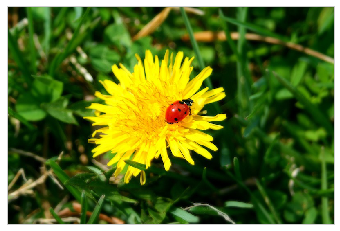

In [117]:
def plot_img(img): 
    plt.imshow(img)
    plt.grid(None)
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.gca().axes.get_yaxis().set_visible(False)

plot_img(ladybug)

In [118]:
X = ladybug.reshape(-1, 3)
X[:5, :]

array([[0.09803922, 0.11372549, 0.00784314],
       [0.09411765, 0.10980392, 0.00392157],
       [0.09411765, 0.11372549, 0.        ],
       [0.10196079, 0.11372549, 0.        ],
       [0.09803922, 0.11372549, 0.00784314]], dtype=float32)

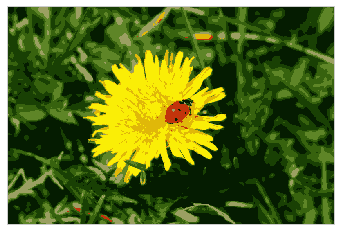

In [119]:
kmeans = KMeans(n_clusters=8).fit(X)

segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(ladybug.shape)

plot_img(segmented_img)

[Saved variables '' to file '/Users/admin/Developer/Python/100DaysOfPython/HandsOnMachineLearningWithScikitLearnAndTensorFlow/caches/ch09_ladybug_silhouetteplot.pkl'.]


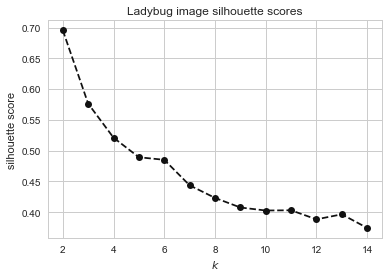

In [120]:
%%cache -d caches ch09_ladybug_silhouetteplot.pkl

ks = np.arange(2, 15)
sil_scores = []

for k in ks:
    km = KMeans(n_clusters=k).fit(X)
    # Sample the data for silhouette score (too slow, otherwise).
    sample_idx = np.random.randint(0, len(X), 5000)
    X_sample = X[sample_idx, :]
    label_sample = km.labels_[sample_idx]
    sil_scores.append(silhouette_score(X_sample, label_sample))

plt.plot(ks, sil_scores, 'k--o')
plt.xlabel('$k$')
plt.ylabel('silhouette score')
plt.title('Ladybug image silhouette scores')
plt.show()

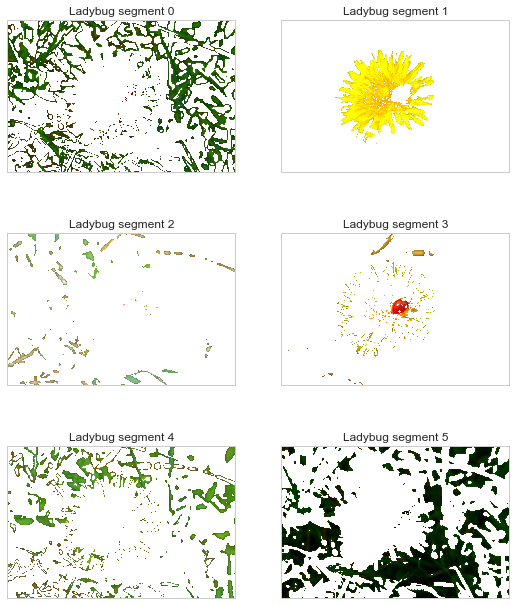

In [121]:
# Subjective judgement from silhouette scores
best_k = 6

kmeans = KMeans(n_clusters=best_k).fit(X)

fig = plt.figure(figsize=(9, 15))
o3 = np.ones(3)

for i in range(best_k):
    plt.subplot(4, 2, i+1)
    partial_img = [x if l == i else o3 for x, l in zip(X, kmeans.labels_)]
    partial_img = np.concatenate(partial_img).reshape(X.shape)
    plot_img(partial_img.reshape(ladybug.shape))
    plt.title(f'Ladybug segment {i}')

plt.show()